In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import pi, sin, cos
import numpy as np
import openmc

In [2]:
#Materials
fuel = openmc.Material(name='fuel')
fuel.add_element('U', 1.0)
fuel.add_element('O', 2.0)
fuel.set_density('g/cm3', 10.0)

clad = openmc.Material(name='zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.0)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H2', 2.0)
heavy_water.add_nuclide('O16', 1.0)
heavy_water.add_s_alpha_beta('c_D_in_D2O')
heavy_water.set_density('g/cm3', 1.1)

In [3]:
#Defining the Dimensions in the Model

#Outer radius of the fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

#Pressure Tube and calendria radii
pressure_tube_ir = 5.16890
pressure_tube_or = 5.60320
calendria_ir = 6.44780
calendria_or = 6.58750

#Radius to center of each ring of fuel pins
ring_radii = np.array([0, 1.4885, 2.8755, 4.3305])

In [4]:
#Creating the annular regions filled with heavy water

#Surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
              (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    #Create annular region
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]

    water_cells.append(openmc.Cell(fill=heavy_water, region=water_region))

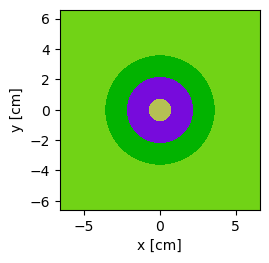

In [5]:
#Checking the geometry
plot_args = {'width': (2*calendria_or, 2*calendria_or)}
bundle_universe = openmc.Universe(cells=water_cells)
bundle_universe.plot(**plot_args)
plt.show()

In [6]:
#Creating a Universe for the fuel pin
#Dont need to put water on the ouside of the cladding because it will be truncated by a higher universe
surf_fuel = openmc.ZCylinder(r=r_fuel)

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
clad_cell = openmc.Cell(fill=clad, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))

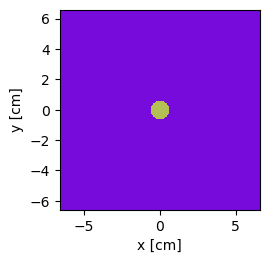

In [7]:
pin_universe.plot(**plot_args)
plt.show()

In [8]:
#Goes through each ring to create a cell containing the fuel pin universe
#Modify the region of the water cell to include everything outside the fuel pin
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        #Determine location of the center of pin
        theta = (a + j/n*360) * pi/180
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        water_cells[i].region &= +pin_boundary

        #Create each fuel pin --- note that we explcitly assign an ID so
        #that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x,y,0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

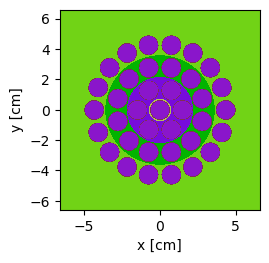

In [9]:
bundle_universe.plot(**plot_args)
plt.show()

In [20]:
#Create cells for the pressure tube and calendria
pt_inner = openmc.ZCylinder(r=pressure_tube_ir)
pt_outer = openmc.ZCylinder(r=pressure_tube_or)
calendria_inner = openmc.ZCylinder(r=calendria_ir)
calendria_outer = openmc.ZCylinder(r=calendria_or, boundary_type='vacuum')

#Then put the bundle in the middle of the pressure tube
bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(cells=[bundle, pressure_tube, v1, calendria])

In [21]:
#Exporting to xml
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

materials = openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

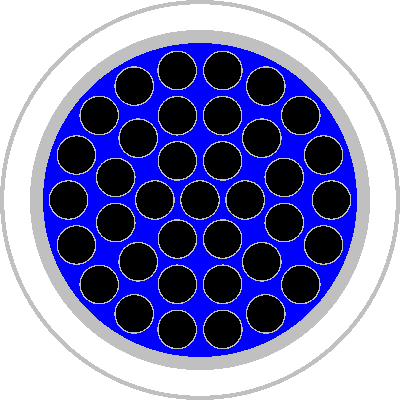

In [22]:
#Plotting
plot = openmc.Plot.from_geometry(geometry)
plot.color_by = 'material'
plot.colors = {
    fuel: 'black',
    clad: 'silver',
    heavy_water: 'blue'
}
plot.to_ipython_image()

In [28]:
#Model Settings
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = openmc.IndependentSource(space=openmc.stats.Point())
settings.export_to_xml()

In [29]:
#Setting up the tally
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]
fuel_tally.scores = ['flux']

tallies = openmc.Tallies([fuel_tally])
tallies.export_to_xml()

In [30]:
#Running the Model
openmc.run(output=True)

[v5:83810] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
  

In [31]:
#Viewing the Results
with openmc.StatePoint('statepoint.{}.h5'.format(settings.batches)) as sp:
    output_tally = sp.get_tally()
    df = output_tally.get_pandas_dataframe()

df

level 1      level 2      level 3      distribcell nuclide score     mean  \
      univ cell    univ cell    univ cell                                      
        id   id      id   id      id   id                                      
0        4   52       1  100       2    5           0   total  flux 1.96e-01   
1        4   52       1  200       2    5           1   total  flux 1.81e-01   
2        4   52       1  201       2    5           2   total  flux 1.84e-01   
3        4   52       1  202       2    5           3   total  flux 1.90e-01   
4        4   52       1  203       2    5           4   total  flux 1.88e-01   
5        4   52       1  204       2    5           5   total  flux 1.93e-01   
6        4   52       1  205       2    5           6   total  flux 1.81e-01   
7        4   52       1  300       2    5           7   total  flux 1.51e-01   
8        4   52       1  301       2    5           8   total  flux 1.54e-01   
9        4   52       1  302       2    5           9   total  flux 1.57e-01   
10       4   52       1  303       2    5          10   total  flux 1.55e-01   
11       4   52       1  304       2    5          11   total  flux 1.57e-01   
12       4   52       1  305       2    5          12   total  flux 1.35e-01   
13       4   52       1  306       2    5          13   total  flux 1.45e-01   
14       4   52       1  307       2    5          14   total  flux 1.54e-01   
15       4   52       1  308       2    5          15   total  flux 1.67e-01   
16       4   52       1  309       2    5          16   total  flux 1.65e-01   
17       4   52       1  310       2    5          17   total  flux 1.55e-01   
18       4   52       1  311       2    5          18   total  flux 1.54e-01   
19       4   52       1  400       2    5          19   total  flux 1.10e-01   
20       4   52       1  401       2    5          20   total  flux 1.12e-01   
21       4   52       1  402       2    5          21   total  flux 1.08e-01   
22       4   52       1  403       2    5          22   total  flux 1.05e-01   
23       4   52       1  404       2    5          23   total  flux 1.04e-01   
24       4   52       1  405       2    5          24   total  flux 1.04e-01   
25       4   52       1  406       2    5          25   total  flux 1.03e-01   
26       4   52       1  407       2    5          26   total  flux 1.15e-01   
27       4   52       1  408       2    5          27   total  flux 1.09e-01   
28       4   52       1  409       2    5          28   total  flux 1.09e-01   
29       4   52       1  410       2    5          29   total  flux 1.10e-01   
30       4   52       1  411       2    5          30   total  flux 1.05e-01   
31       4   52       1  412       2    5          31   total  flux 1.13e-01   
32       4   52       1  413       2    5          32   total  flux 1.11e-01   
33       4   52       1  414       2    5          33   total  flux 1.08e-01   
34       4   52       1  415       2    5          34   total  flux 1.10e-01   
35       4   52       1  416       2    5          35   total  flux 1.18e-01   
36       4   52       1  417       2    5          36   total  flux 1.11e-01   

   std. dev.  
              
              
0   4.94e-03  
1   7.11e-03  
2   8.90e-03  
3   8.38e-03  
4   4.97e-03  
5   6.19e-03  
6   8.48e-03  
7   3.48e-03  
8   9.99e-03  
9   7.54e-03  
10  4.19e-03  
11  6.33e-03  
12  7.49e-03  
13  5.61e-03  
14  3.83e-03  
15  6.17e-03  
16  5.04e-03  
17  3.40e-03  
18  3.97e-03  
19  5.40e-03  
20  4.07e-03  
21  4.92e-03  
22  2.67e-03  
23  9.52e-03  
24  7.80e-03  
25  4.16e-03  
26  6.36e-03  
27  4.42e-03  
28  4.70e-03  
29  4.34e-03  
30  3.67e-03  
31  7.88e-03  
32  7.55e-03  
33  4.93e-03  
34  3.77e-03  
35  5.22e-03  
36  5.11e-03